In [23]:
# ==============================
# 📊 Librerías de Manipulación de Datos
# ==============================
import pandas as pd
import numpy as np
import calendar

# ==============================
# 📊 Visualización de Datos
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns


# ==============================
# ⚡ Machine Learning y Modelado
# ==============================
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV

# ==============================
# 📊 Evaluación del Modelo
# ==============================
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, roc_curve, auc, accuracy_score
)

# ==============================
# 🔍 Interpretabilidad del Modelo (SHAP)
# ==============================
import shap

# ==============================
# ✅ Guardado del Modelo
# ==============================
import pickle
import os

In [24]:
path_data = "/workspaces/AK-EA-GG_ProyectoFinalDS-ML/data/processed/" 

df_train = pd.read_csv(path_data + "clean_train.csv")

In [25]:
# Separar X e y
X_train = df_train.drop(columns=['loan_status'])
y_train = df_train['loan_status']

print("✅ Datos cargados y separados correctamente.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

✅ Datos cargados y separados correctamente.
X_train shape: (56000, 37)
y_train shape: (56000,)


In [26]:
path_data = "/workspaces/AK-EA-GG_ProyectoFinalDS-ML/data/processed/" 

df_test = pd.read_csv(path_data + "clean_test.csv")

In [27]:
# Separar X e y
X_test = df_test.drop(columns=['loan_status'])
y_test = df_test['loan_status']

print("✅ Datos cargados y separados correctamente.")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

✅ Datos cargados y separados correctamente.
X_test shape: (14000, 37)
y_test shape: (14000,)


In [28]:
# Cargar modelo
model_dir = '/workspaces/AK-EA-GG_ProyectoFinalDS-ML/models/'


with open(model_dir + 'xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

In [29]:
# Calcular el ratio de balance entre clases
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Definir el espacio de hiperparámetros optimizado
param_dist = {
    'max_depth': [3, 5, 7],             # Mantener solo los más efectivos
    'learning_rate': [0.01, 0.05, 0.1], # Tasa de aprendizaje efectiva
    'n_estimators': [100, 300, 500],    # Número de árboles optimizado
    'subsample': [0.7, 0.8, 1.0],       # Mantener solo las mejores opciones
    'colsample_bytree': [0.7, 0.8, 1.0],# Mantener solo las mejores opciones
    'scale_pos_weight': [ratio, ratio * 1.5]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='roc_auc',
    n_iter=50,           # Probar solo 50 combinaciones aleatorias
    cv=5,                 # Validación cruzada de 5
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entrenar el RandomizedSearchCV
random_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y AUC
print(f"Mejores parámetros: {random_search.best_params_}")
print(f"Mejor AUC: {random_search.best_score_:.4f}")

# Usar el mejor modelo encontrado
best_xgb = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=300, scale_pos_weight=4.182785747339195, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=300, scale_pos_weight=4.182785747339195, subsample=0.7; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=300, scale_pos_weight=4.182785747339195, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=300, scale_pos_weight=4.182785747339195, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=300, scale_pos_weight=6.274178621008792, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=300, scale_pos_weight=4.182785747339195, subsample=0.7; total time=   3.8s
[CV] END colsample_bytree=

Threshold óptimo: 0.7000000000000001


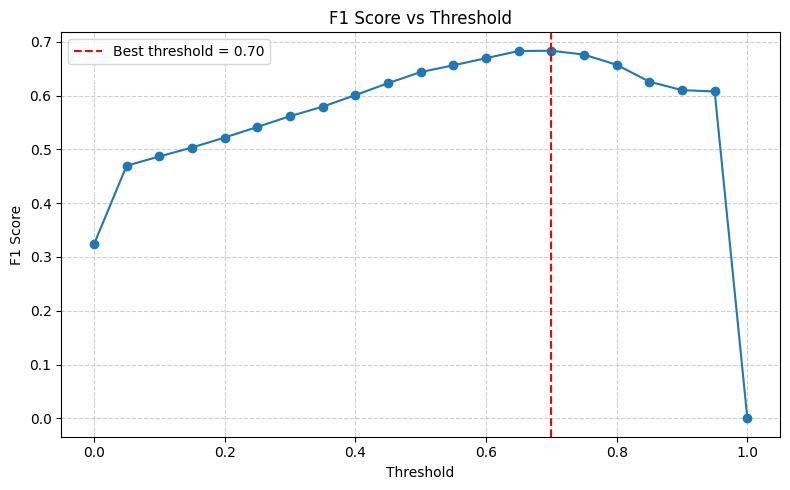

In [30]:
# Obtener las probabilidades del modelo (probabilidad de la clase positiva)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Definir lista de thresholds
thresholds = np.arange(0.0, 1.05, 0.05)
f1_scores = []

# Probar cada threshold y calcular F1-Score
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

# Seleccionar el threshold óptimo
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold óptimo: {optimal_threshold}")

# Graficar F1-Score vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f"Best threshold = {optimal_threshold:.2f}")
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
# Predecir con el threshold óptimo
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Calcular métricas
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)
roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred_optimal)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")
print(f"Accuracy score: {accuracy:.4f}")

Precision: 0.7391
Recall: 0.6357
F1-Score: 0.6835
AUC: 0.9246
Accuracy score: 0.8864


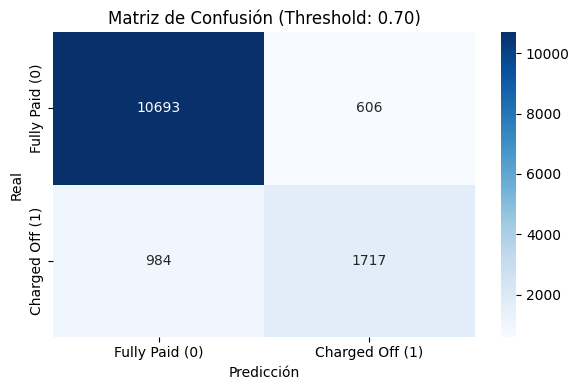

In [32]:
# Calcular la matriz de confusión con el threshold óptimo
y_pred_opt = (y_prob >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_opt)

# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fully Paid (0)', 'Charged Off (1)'],
            yticklabels=['Fully Paid (0)', 'Charged Off (1)'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión (Threshold: {optimal_threshold:.2f})')
plt.tight_layout()
plt.show()

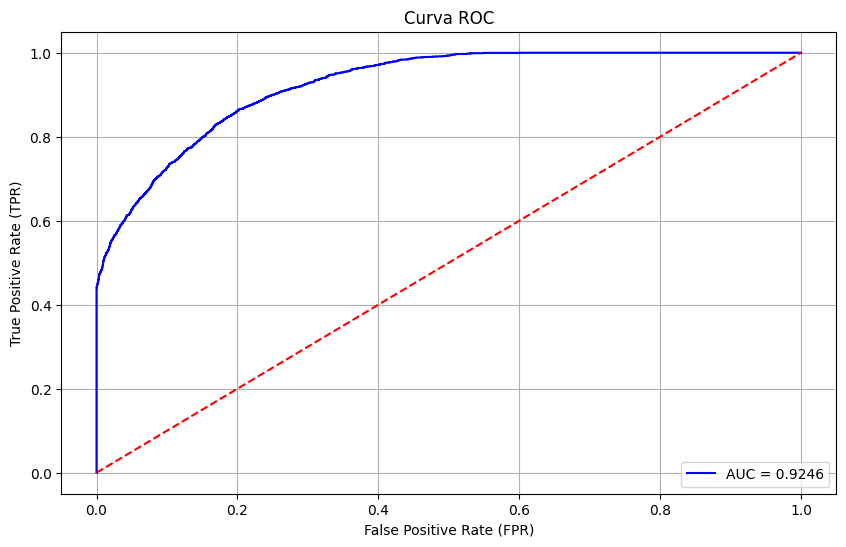

In [33]:
# Calcular FPR, TPR y thresholds para la curva ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("Curva ROC")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

 99%|===================| 13893/14000 [01:00<00:00]        

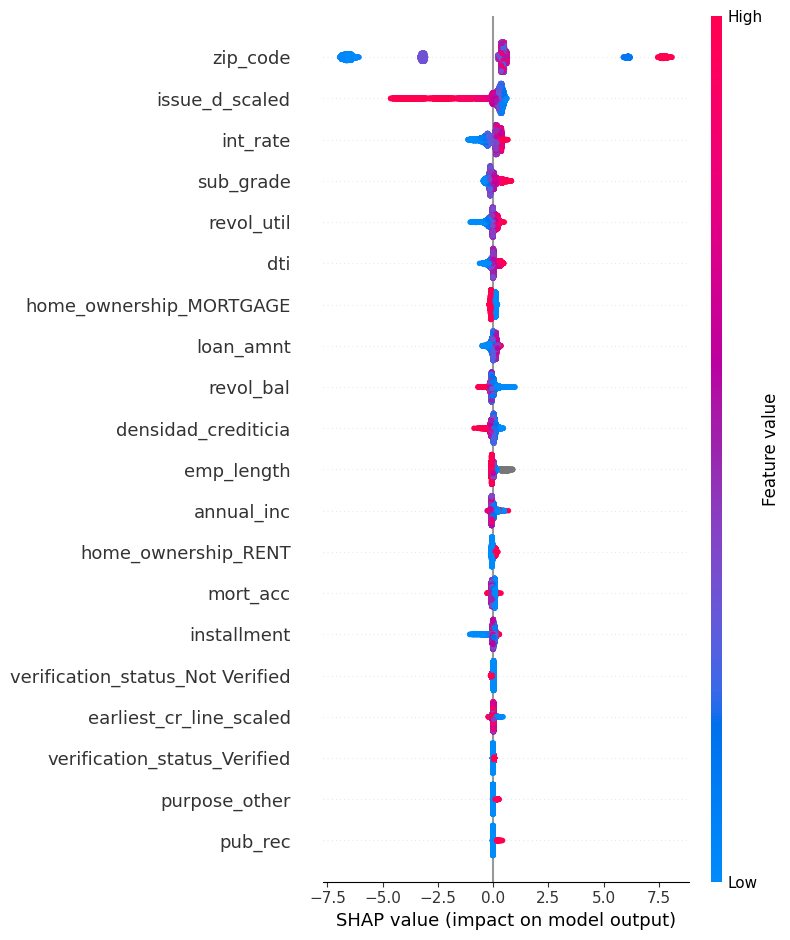

In [34]:
# Crear el Explainer de SHAP para XGBoost
explainer = shap.Explainer(best_xgb, X_train)

# Calcular valores SHAP para el conjunto de prueba
shap_values = explainer(X_test)

# Resumen global de valores SHAP
shap.summary_plot(shap_values, X_test)

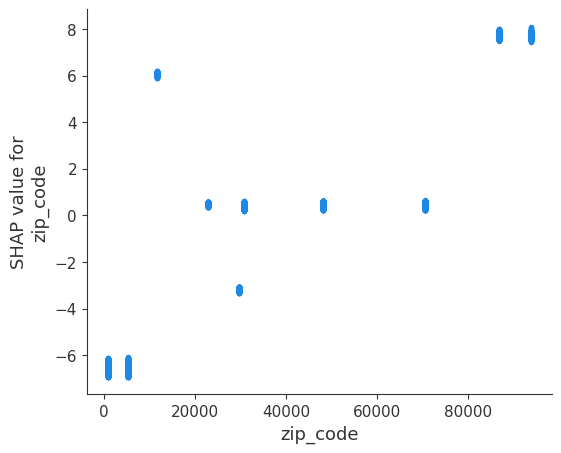

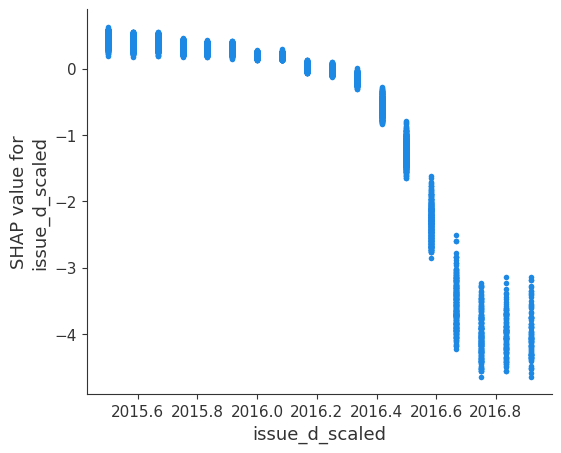

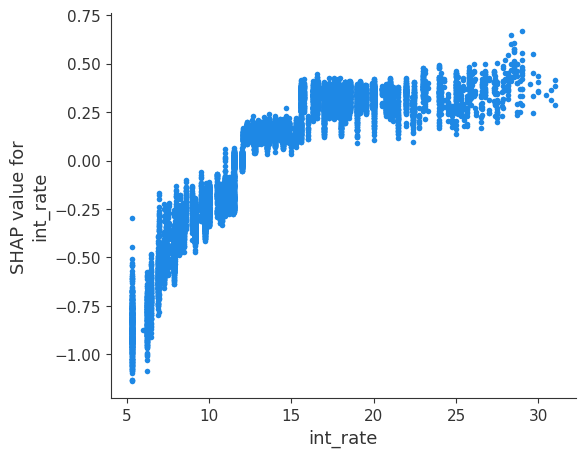

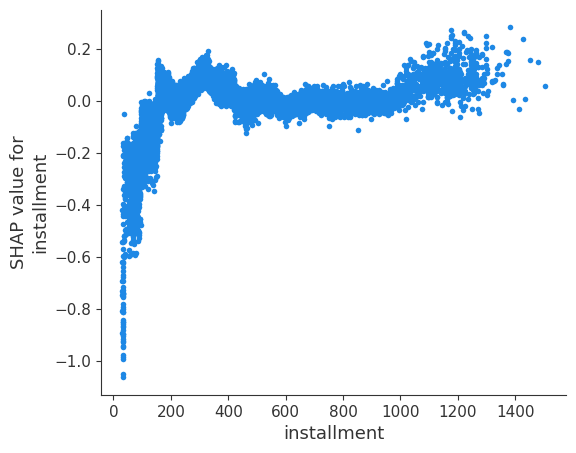

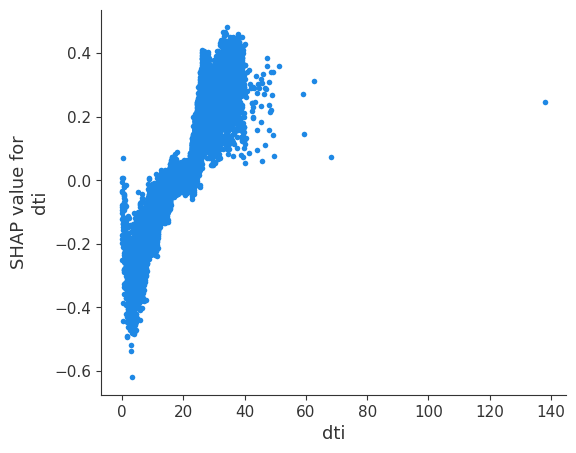

In [35]:
# Verificar que X_test está en formato DataFrame float
X_test_float = X_test.astype(float)

# Convertir valores SHAP al formato esperado (array)
shap_values_array = shap_values.values if hasattr(shap_values, "values") else shap_values

# Lista de variables clave para análisis
variables_clave = ["zip_code", "issue_d_scaled", "int_rate", "installment", "dti"]

# Crear los dependence plots correctamente
for variable in variables_clave:
    shap.dependence_plot(variable, shap_values_array, X_test_float, interaction_index=None)

<Figure size 1000x800 with 0 Axes>

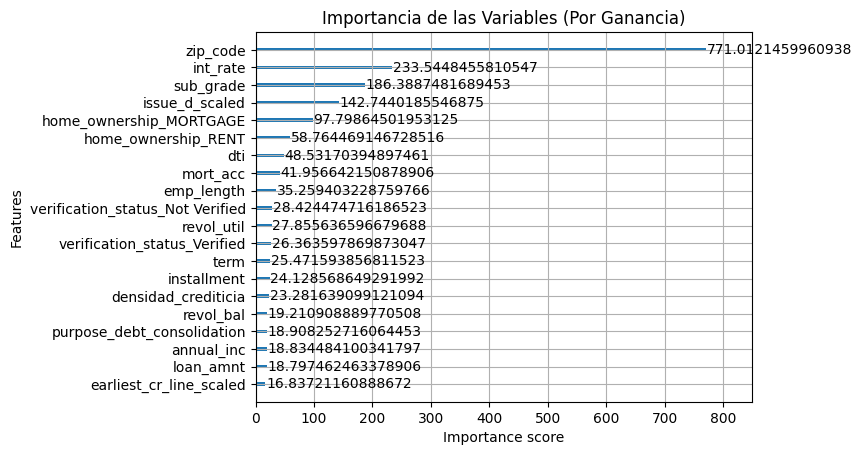

In [36]:
# Visualización de las variables más importantes del modelo (por Ganancia)
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, importance_type='gain', max_num_features=20)
plt.title("Importancia de las Variables (Por Ganancia)")
plt.show()

In [37]:
# Definir la ruta donde se guardarán los modelos
model_dir = '/workspaces/AK-EA-GG_ProyectoFinalDS-ML/models'

# Ruta del archivo
best_xgb_path = os.path.join(model_dir, 'best_xgb_final.pkl')

# Guardar modelo y threshold juntos como una tupla
with open(best_xgb_path, 'wb') as model_file:
    pickle.dump((best_xgb, optimal_threshold), model_file)

print(f"Modelo best_xgb guardado en: {best_xgb_path}")

Modelo best_xgb guardado en: /workspaces/AK-EA-GG_ProyectoFinalDS-ML/models/best_xgb_final.pkl
